In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from keras import layers

import matplotlib.pyplot as plt

## Load the MNIST dataset

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,  # Not necessary, since the dataset is stored in a single file
    as_supervised=True,  # Returns tuple (img, label) otherwise dict
    with_info=True,
)

## Data Preprocessing

In [3]:
# Normalize the grayscale value of the images
def normalize_img(image, label):
    """
    Normalize images
    :param image: uint8 tensor
    :param label: int tensor
    :return: float32 tensor
    """
    return tf.cast(image, tf.float32) / 255., label


BATCH_SIZE = 64

# Apply the normalization function to the dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Cache the dataset in memory for faster training
ds_train = ds_train.cache()
# Shuffle the dataset for true randomness
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# Batch the dataset
ds_train = ds_train.batch(BATCH_SIZE)
# Prefetch the dataset for faster training
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
# Apply the same steps to the test dataset (no need to shuffle since it's the test dataset)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 6

model = tf.keras.models.Sequential()
# Input layer with 28x28x1 shape
model.add(layers.InputLayer(shape=(28, 28, 1)))
# 16 kernels of size 3x3 => (28-3+1)x(28-3+1)x16 = 26x26x16 output shape
model.add(layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
# 2x2 pooling => 26/2x26/2x16 = 13x13x16 output shape
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Flatten the 13x13x16 tensor to a 2704x1 tensor
model.add(layers.Flatten())
# Fully connected layer with 128 neurons
model.add(layers.Dense(128, activation='relu'))
# Softmax for multi-class classification => probability distribution over the 10 classes
model.add(layers.Dense(10, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),  # Adam optimizer with learning rate of 0.001
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    # Sparse categorical cross entropy loss for multi-class classification
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=NUM_EPOCHS,
    validation_data=ds_test,
)

Epoch 1/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.4056 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.0861 - val_sparse_categorical_accuracy: 0.9750
Epoch 2/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0768 - sparse_categorical_accuracy: 0.9770 - val_loss: 0.0588 - val_sparse_categorical_accuracy: 0.9808
Epoch 3/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0508 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.0487 - val_sparse_categorical_accuracy: 0.9843
Epoch 4/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0340 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.0481 - val_sparse_categorical_accuracy: 0.9838
Epoch 5/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0246 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.0480 - val_sparse_categorical_accuracy: 0.9846
Epoch 6/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0195 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.0493 - val_sparse_categorical_accuracy: 0.9848


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       346,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,043,072 (3.98 MB)

 Trainable params: 347,690 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 695,382 (2.65 MB)

In [7]:
test_scores = model.evaluate(ds_test, verbose=2)
loss_cnn = test_scores[0] * 100
accuracy_cnn =  test_scores[1] * 100
print('Test loss:', loss_cnn)
print('Test accuracy:', accuracy_cnn)

157/157 - 0s - 2ms/step - loss: 0.0493 - sparse_categorical_accuracy: 0.9848
Test loss: 4.925844445824623
Test accuracy: 98.47999811172485


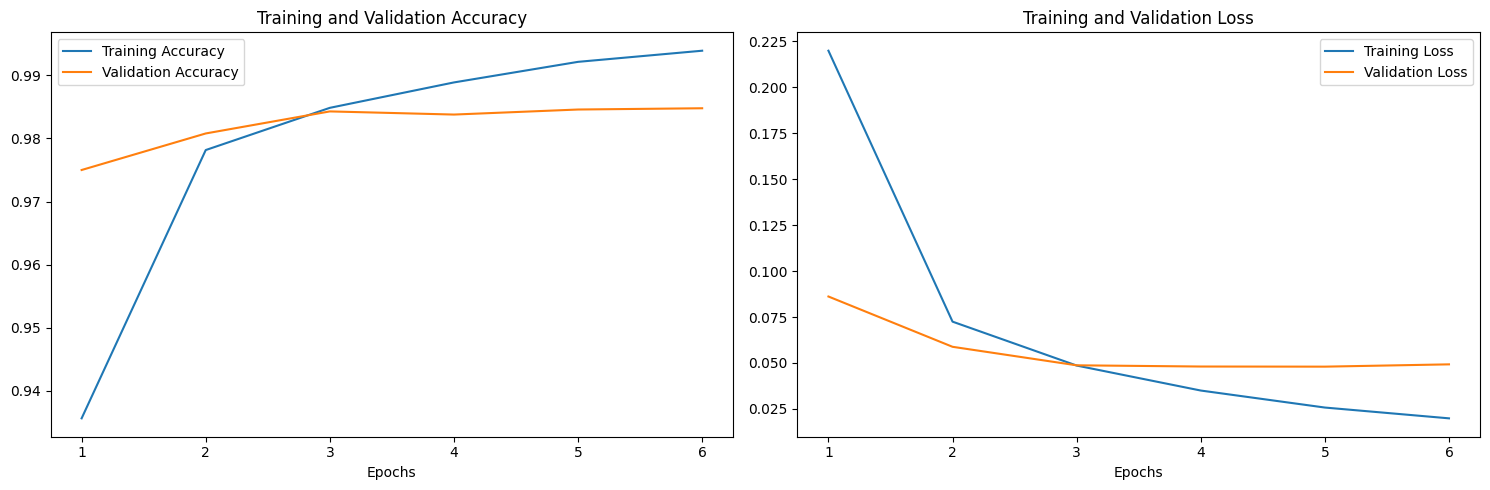

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

# Plot Training and Validation Accuracy on the first subplot
axs[0].plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
axs[0].plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Loss on the second subplot
axs[1].plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
axs[1].plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

plt.tight_layout()
plt.show()

In [10]:
model.save('./../models/mnist_cnn.keras')